# Basic plots, data exploration

Outdated notebook.

This notebook contains a lot of plots related to epochs, regions, subregions.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func

In [2]:
figfolder = '../figs/basic_plots/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

In [3]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


#r2_new = pickle.load(open(datafolder + 'r2_data_dict_smallwindows_v3.pkl', 'rb'))
r2_new = pickle.load(open(datafolder + 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl', 'rb'))


ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']
timeshifts = np.arange(-30,32,2, dtype = int)

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [4]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

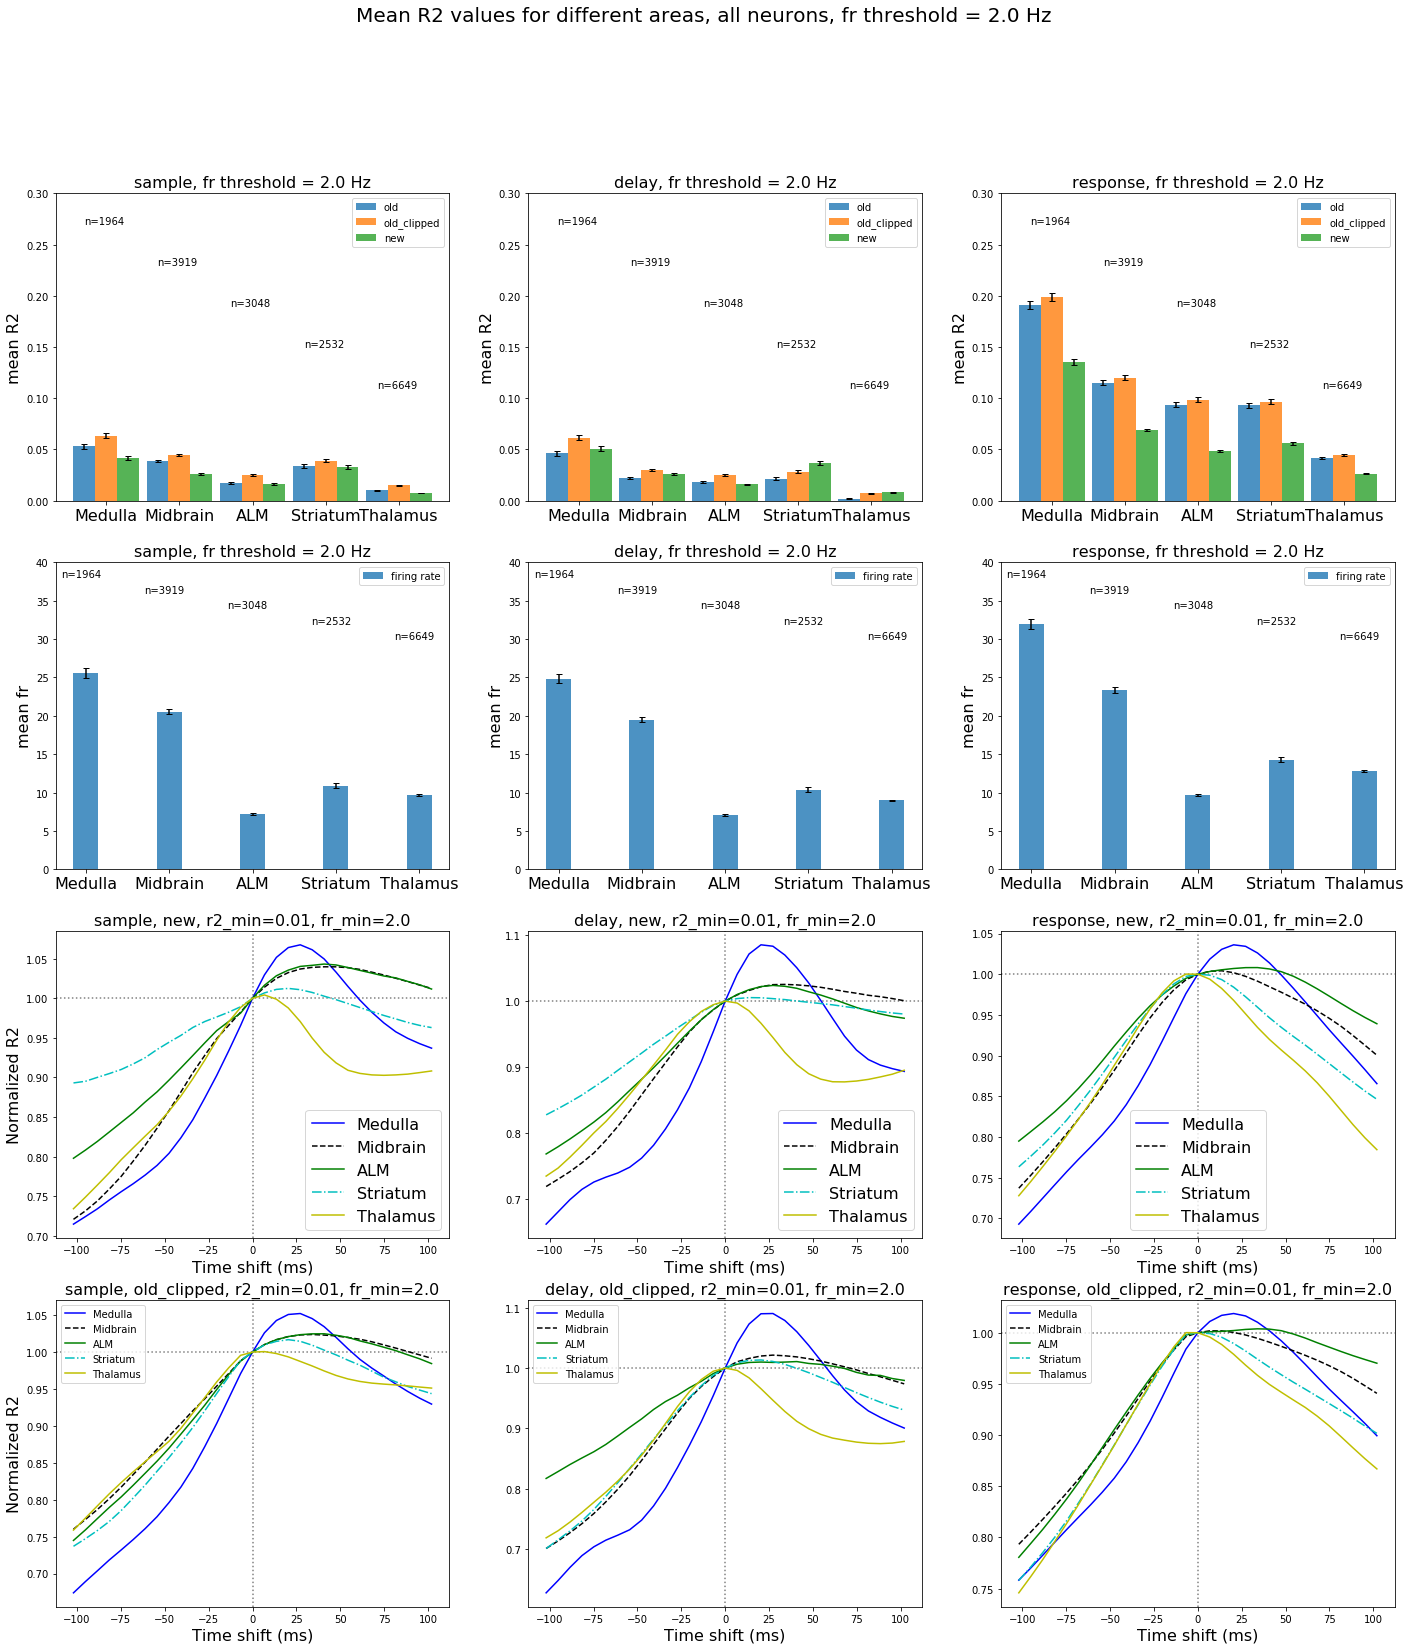

In [5]:
fr_cutoff = 2
r2_threshold = 0.01
lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

f, _ = plt.subplots(4,3,figsize=(24,26))
f.suptitle('Mean R2 values for different areas, all neurons, fr threshold = %.1f Hz'%fr_cutoff, fontsize=20)
for iepoch, epoch in enumerate(epochs):
    plt.subplot(4,3,iepoch+1)
    for ir2, r2method in enumerate(r2_methods):
        r2method_string = method_to_string[r2method]
        r2 = r2_new['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        fr = r2_new['5_0']['avg_fr'].copy()

        if r2method == 'old_clipped':
            r2[r2<0] = 0

        fr_inds = np.where(fr>fr_cutoff)[0]

        ccf_labels = r2_new['5_0']['ccf_labels'].copy()

        area_values = []
        area_sems = []
        n_neurons = []
        for j, area in enumerate(areas):
            if area == 'ALM':
                inds = alm_inds.copy()
            else:
                inds = get_single_area_inds(area, df, ccf_labels)
            inds = np.intersect1d(inds, fr_inds)
            n_neurons.append(len(inds))
            mean = r2[inds].mean()
            std = r2[inds].std()
            sem = std/np.sqrt(inds.shape[0])
            area_values.append(mean)
            area_sems.append(sem)

        
        plt.bar(np.arange(0,len(areas)) + (- 0.3 + ir2*0.3), 
                area_values, yerr = area_sems, alpha = 0.8, 
                capsize = 3, width=0.3, label = r2method)
        
        
        if ir2 == 0: 
            plt.xticks(np.arange(0,len(areas)), areas, rotation = 0, fontsize = 16);
            plt.ylabel('mean R2',fontsize = 16)
            plt.title('%s, fr threshold = %.1f Hz'%(epoch, fr_cutoff), fontsize = 16)
            for j in range(len(areas)):
                plt.text(j-0.3,0.27-0.04*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.30)
    plt.legend()

    plt.subplot(4,3,3 + iepoch+1)
    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    ccf_labels = r2_new['5_0']['ccf_labels'].copy()

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds.copy()
        else:
            inds = get_single_area_inds(area, df, ccf_labels)
        inds = np.intersect1d(inds, fr_inds)
        n_neurons.append(len(inds))
        mean = fr[inds].mean()
        std = fr[inds].std()
        sem = std/np.sqrt(inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    
    plt.bar(np.arange(0,len(areas)), 
            area_values, yerr = area_sems, alpha = 0.8, 
            capsize = 3, width=0.3, label = 'firing rate')
        
        
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0, fontsize = 16);
    plt.ylabel('mean fr', fontsize = 16)
    plt.title('%s, fr threshold = %.1f Hz'%(epoch, fr_cutoff), fontsize = 16)
    for j in range(len(areas)):
        plt.text(j-0.3,38-2*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')


    plt.ylim(0,40)
    plt.legend()


    r2_method = 'new'
    fr = r2_new['5_0']['avg_fr'].copy()
    r2 = []
    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_cutoff)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
    plt.subplot(4,3, 6 + iepoch+1)
    plt.title('%s, %s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_method,r2_threshold,fr_cutoff), fontsize = 16)
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds.copy()
        else:
            inds = get_single_area_inds(area, df, ccf_labels)


        inds = np.intersect1d(inds, threshold_inds)
        avg_r2 = r2[:,inds].mean(axis = 1)

        plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



    a,b = plt.xlim()
    plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    plt.xlim(a,b)

    a,b = plt.ylim()
    plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    plt.ylim(a,b)

    plt.xlabel('Time shift (ms)', fontsize = 16)
    if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
    plt.legend(fontsize = 16)

    r2_method = 'old_clipped'
    fr = r2_new['5_0']['avg_fr'].copy()
    r2 = []
    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_cutoff)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
    plt.subplot(4,3, 9 + iepoch+1)
    plt.title('%s, %s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_method,r2_threshold,fr_cutoff), fontsize = 16)
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds.copy()
        else:
            inds = get_single_area_inds(area, df, ccf_labels)


        inds = np.intersect1d(inds, threshold_inds)
        avg_r2 = r2[:,inds].mean(axis = 1)

        plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



    a,b = plt.xlim()
    plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    plt.xlim(a,b)

    a,b = plt.ylim()
    plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    plt.ylim(a,b)

    plt.xlabel('Time shift (ms)', fontsize = 16)
    if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
    plt.legend()




plt.savefig(figfolder + 'mean_r2_all_neurons_fr_cutoff_%.1f.png'%fr_cutoff)
plt.show()
plt.close()

## Further areas

In [13]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

short_names_correct_allen = [
    'AM',
    'CM',
    'MD',
    'MG',
    'PCN',
    'PF',
    'PO',
    'PVT',
    'RT',
    'SMT',
    'VAL',
    'VM',
    'VPM',    
]

In [14]:
r2_threshold = 0.01
fr_threshold = 2
n_threshold = 100

epoch = 'response'
r2_method = 'new'

thalamus_inds = func.get_inds_for_list_of_regions(thalamus_use_nuclei, df, ccf_labels, alm_inds)

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2 > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

inds = {}
n_neurons = []
i = 0
use_short_names = []
for k,v in thalamus_inds.items():
    _this_inds = np.intersect1d(v, threshold_inds)
    if _this_inds.shape[0] > n_threshold:
        inds[k] = _this_inds
        n_neurons.append(_this_inds.shape[0])
        use_short_names.append(short_names_correct_allen[i])
    i += 1




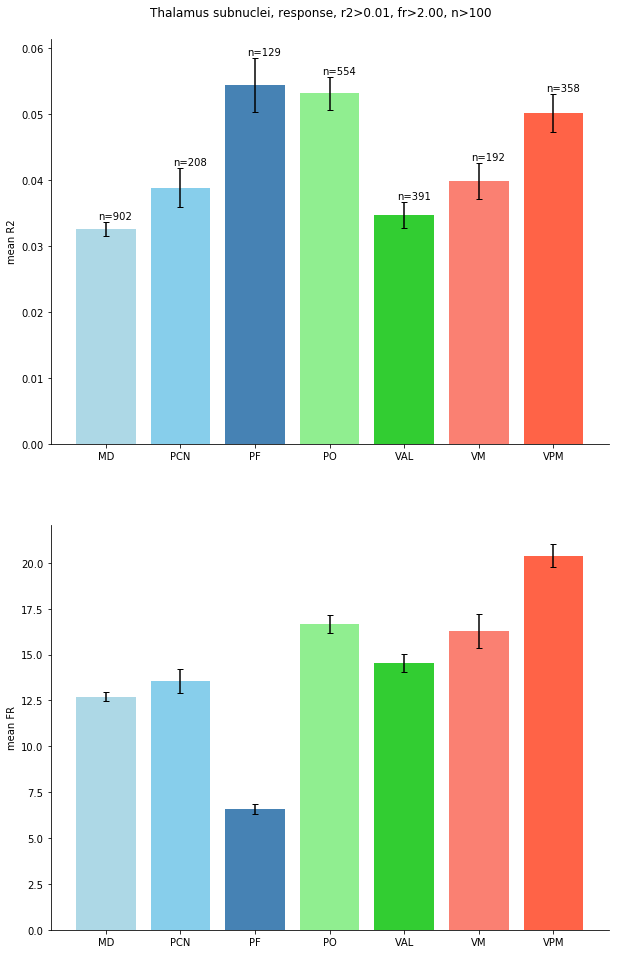

In [15]:
f = plt.figure(figsize=(10,15))

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]


ax_bar = f.add_subplot(2,1,1)

f.suptitle('Thalamus subnuclei, %s, r2>%0.2f, fr>%0.2f, n>%d'%(epoch, r2_threshold, fr_threshold, n_threshold))

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

m, sem = func.get_mean_and_sem_for_subregions(r2, inds, list(inds.keys()))
plt.bar(np.arange(0,len(m)), 
            m, yerr = sem, alpha = 1., color = cc, 
            capsize = 3, width=0.8, label = epoch)

for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
#ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')


ax_bar = f.add_subplot(2,1,2)

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, list(inds.keys()))
plt.bar(np.arange(0,len(m)), 
            m_fr, yerr = sem_fr, alpha = 1., color = cc, 
            capsize = 3, width=0.8, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
#ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_short_names, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

plt.subplots_adjust(top = 0.95)
plt.savefig(figfolder + 'thalamus_subnuclei_%s_r2%0.2f_fr%0.2f_n%d.png'%(epoch, r2_threshold, fr_threshold, n_threshold))


In [16]:
def get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds):
    subregions_annotation_dict = dict()
    for subreg in region_list:
        if subreg == 'ALM':
            continue
        else:
            subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, subregions_annotation_dict)

    if 'ALM' in region_list:
        use_inds = dict()
        use_inds['ALM'] = alm_inds
        for k,v in inds.items():
            use_inds[k] = np.setdiff1d(v, alm_inds)
        
        return use_inds
    
    return inds

def create_one_epoch_barplots(ax, r2_new, inds, subregions_list, axis_names, cc,ylabel, quantity, r2_method = 'new', epoch = 'response', method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    n_neurons = [v.shape[0] for v in inds.values()]
    
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    if quantity == 'r2':
        m, sem = func.get_mean_and_sem_for_subregions(r2, inds, subregions_list)
    elif quantity == 'fr':
        m, sem = func.get_mean_and_sem_for_subregions(fr, inds, subregions_list)
    plt.bar(np.arange(0,len(m)), 
                m, yerr = sem, alpha = 0.8, color = cc, 
                capsize = 3, width=0.5, label = epoch)
    for i in range(len(n_neurons)):
        ax.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()
    _ = ax.set_xticks(np.arange(0,len(m)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    _ = ax.set_ylabel(ylabel)

def create_timeshift_curves_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''} ):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('normalized timeshift curve, %s'%(epoch), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],color = cc[j], ls= 'solid', label = area + ', ' + epoch)

    a,b = ax.set_xlim()
    ax.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_xlim(a,b)

    a,b = ax.set_ylim()
    ax.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_ylim(a,b)

    ax.set_xlabel('Time shift (ms)', fontsize = 16)
    ax.set_ylabel('Normalized R2', fontsize = 16)

def create_timeshift_barplot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('Mean best timeshifts, %s'%(epoch), fontsize = 16)
    means = []
    sems = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_area_r2 = r2[:,this_inds]
        best_timeshift = np.argmax(this_area_r2, axis = 0)

        timeshift_array = 3.4 * timeshifts[best_timeshift]

        avg_timeshift = np.mean(timeshift_array)
        std_timeshift = np.std(timeshift_array)
        sem_timeshift = std_timeshift/np.sqrt(len(timeshift_array))
        means.append(avg_timeshift)
        sems.append(sem_timeshift)


    ax.bar(np.arange(len(means)), means, yerr = sems, color = cc, capsize = 3)
    _= ax.set_xticks(np.arange(len(means)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    ax.set_ylabel('Mean best time shift (ms)', fontsize = 16)  


def create_timeshift_violin_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, fr_threshold=5, r2_threshold=0.02, method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)

    ax.set_title('%s' % (epoch), fontsize=16)

    data_to_plot = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        this_inds = np.intersect1d(this_inds, threshold_inds)
        this_area_r2 = r2[:, this_inds]
        best_timeshift = np.argmax(this_area_r2, axis=0)
        timeshift_array = 3.4 * timeshifts[best_timeshift]  # Assuming this is correct based on your code
        if len(timeshift_array) > 0:
            data_to_plot.append(timeshift_array)
        else:
            data_to_plot.append(np.array([0]))  # Append a zero array if no data

    # Creating violin plots
    parts = ax.violinplot(data_to_plot, points = 1000, showmeans=True, showmedians=False, bw_method=0.3)

    # Coloring each violin plot
    for ipc, pc in enumerate(parts['bodies']):
        pc.set_facecolor(cc[ipc])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    ax.set_xticks(np.arange(1, len(axis_names) + 1))
    ax.set_xticklabels(axis_names, rotation=0)
    ax.set_ylabel('Distribution of best time shift (ms)', fontsize=16)



def create_summary_plot(region_list, color_list, r2_new, timeshifts, epochs, r2_method, axis_names, titlestr,alm_inds, epoch = 'response', method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}, fr_threshold = 5, r2_threshold = 0.02, delta_r2 = 1.2,  n_min = 0):
    inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    #delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    #threshold_inds = np.intersect1d(threshold_inds, delta_inds)

    _inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
    use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

    use_regions = list(use_inds.keys())

    use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]
    f = plt.figure(figsize=(20,20))
    f.suptitle(titlestr + '%s, fr_min = %.2f, r2_min = %.3f, delta_r2 =%.2f'%(epoch,fr_threshold,r2_threshold,delta_r2), fontsize=20)

    ax_bar = f.add_subplot(2,2,1)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean R2', 'r2', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,2)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean FR', 'fr', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,3)
    create_timeshift_curves_plot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch)

    ax_bar = f.add_subplot(2,2,4)
    create_timeshift_barplot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch,)
    plt.subplots_adjust(top=0.95)


In [17]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]


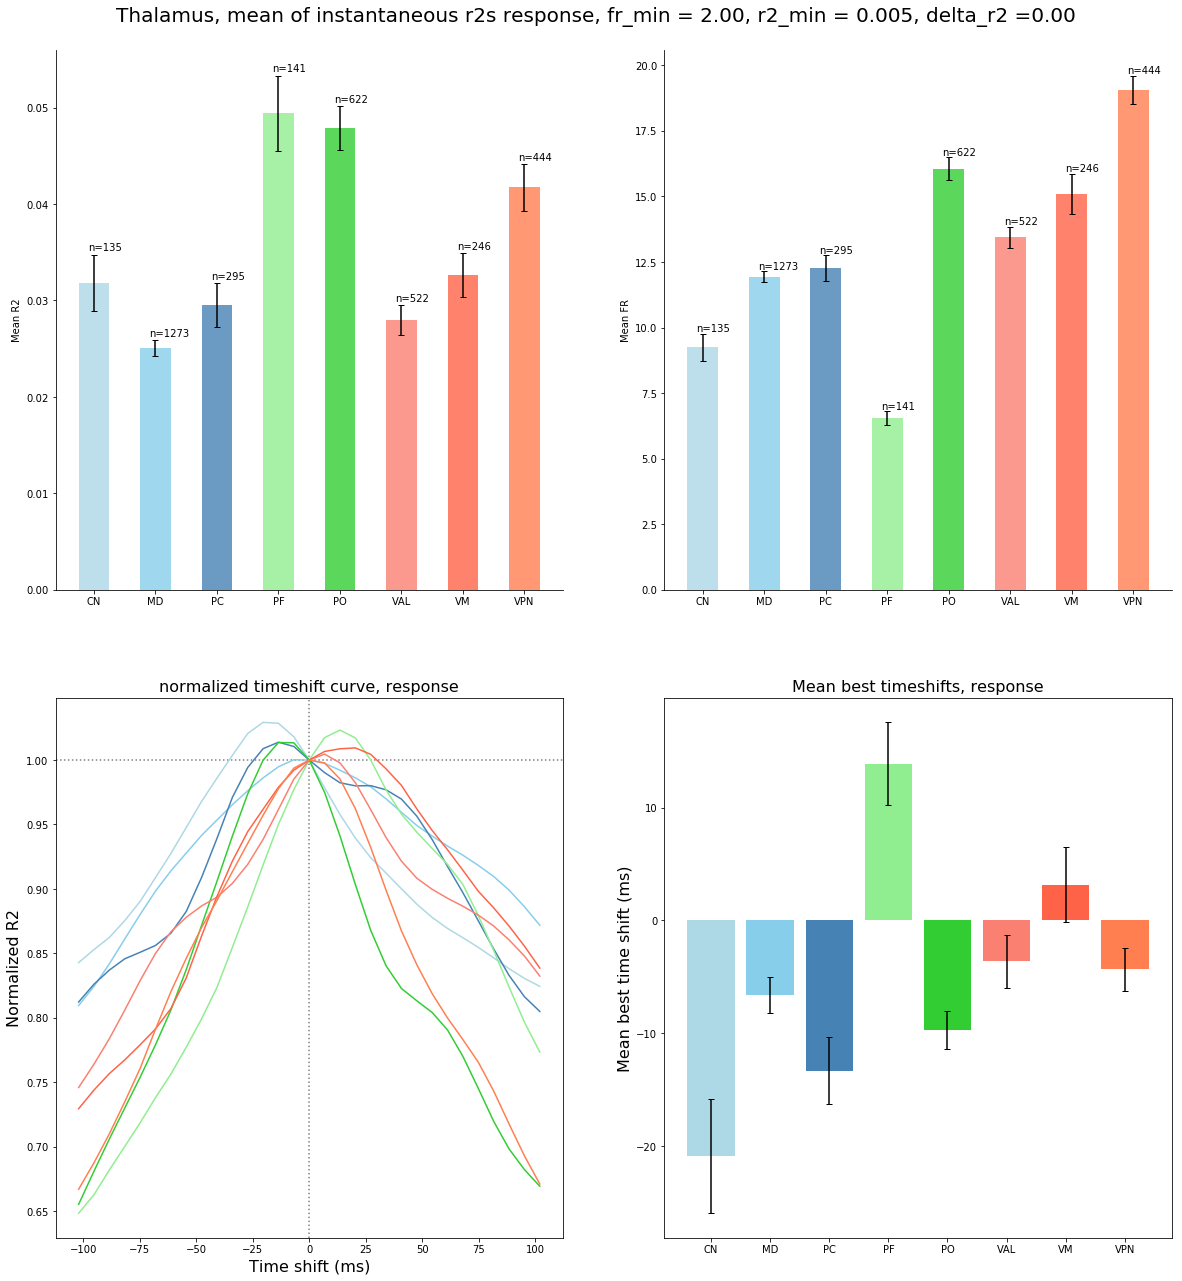

In [18]:
create_summary_plot(thalamus_use_nuclei, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_names, titlestr = 'Thalamus, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=2.0, delta_r2=0.,n_min= 100)
plt.savefig(figfolder + 'thalamus_r2_response.png', bbox_inches = 'tight')

In [19]:
use_midbrain_list = [
    'Midbrain, sensory related',
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    #'Periaqueductal gray',
    #'Cuneiform nucleus',
    'Red nucleus',
    'Pretectal region',
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus',
]

short_midbrain_names = [
    'Sensory',
    'SNR',
    'Reticular',
    'SCM',
    #'PG',
    'Red',
    'Pretectal',
    'SNC',
    'Pendunculopontine',
]

color_list = [
    "gray",
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",
    "red",
    "coral"
]

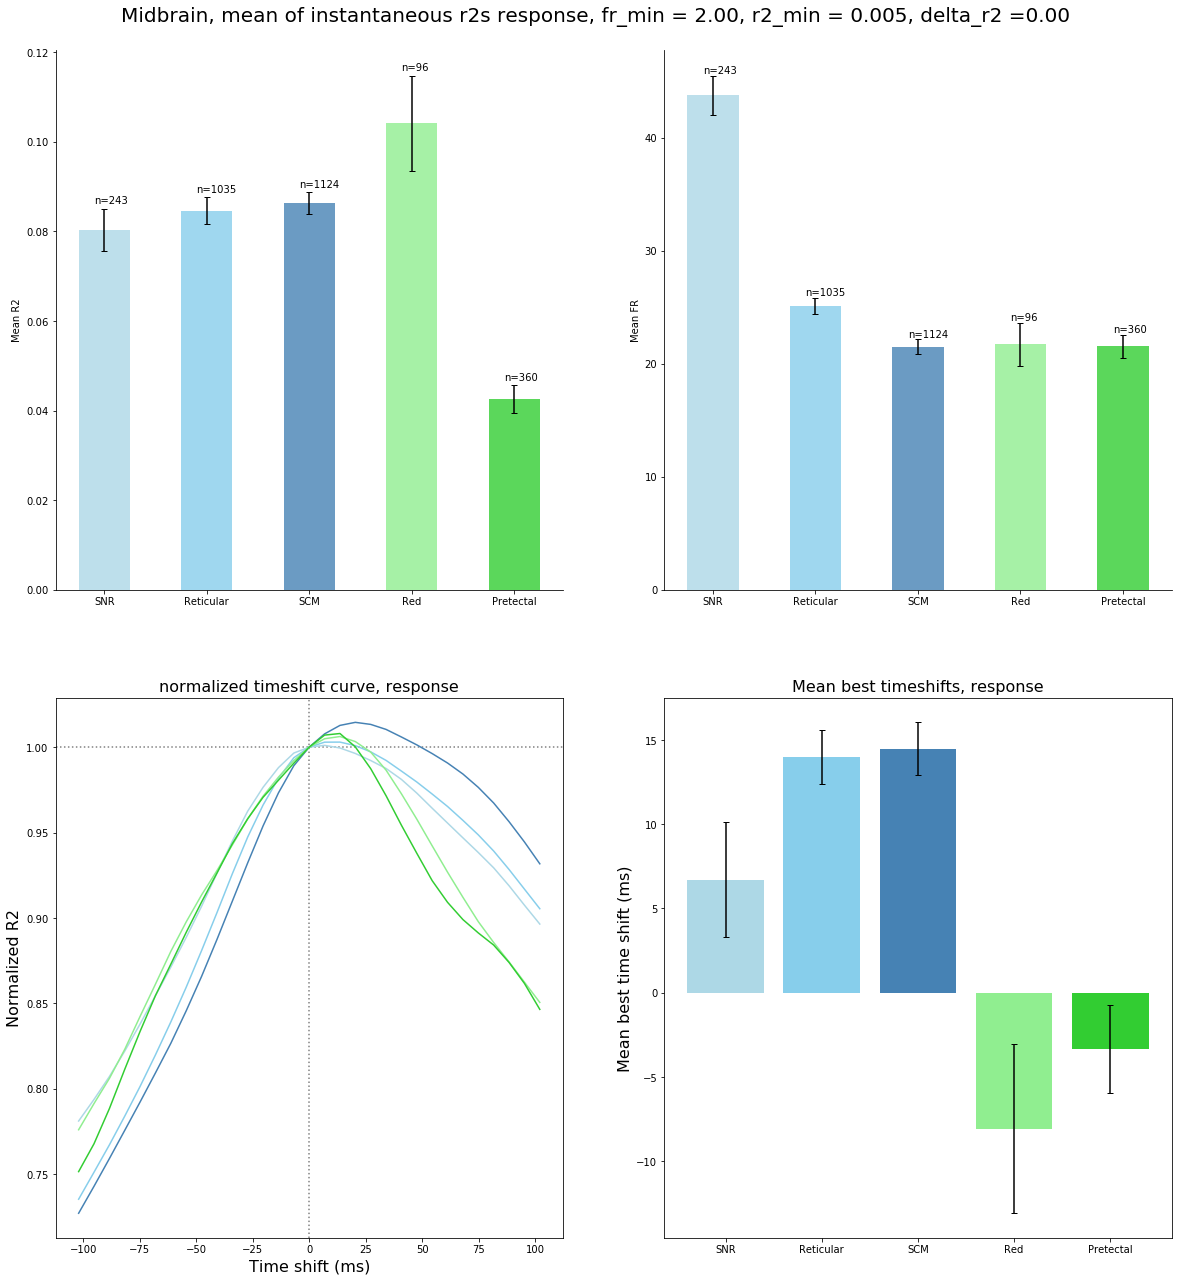

In [20]:
create_summary_plot(use_midbrain_list, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_midbrain_names, titlestr = 'Midbrain, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=2.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'midbrain_r2_response.png', bbox_inches = 'tight')

In [21]:
use_cortex_list = ['ALM',
                   'Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

short_cortex_names = [
    'ALM',
    'Somatosensory',
    'Somatomotor',
    'Auditory',
    'Orbital',
    'Angular',
    'Retrosplenial',
]

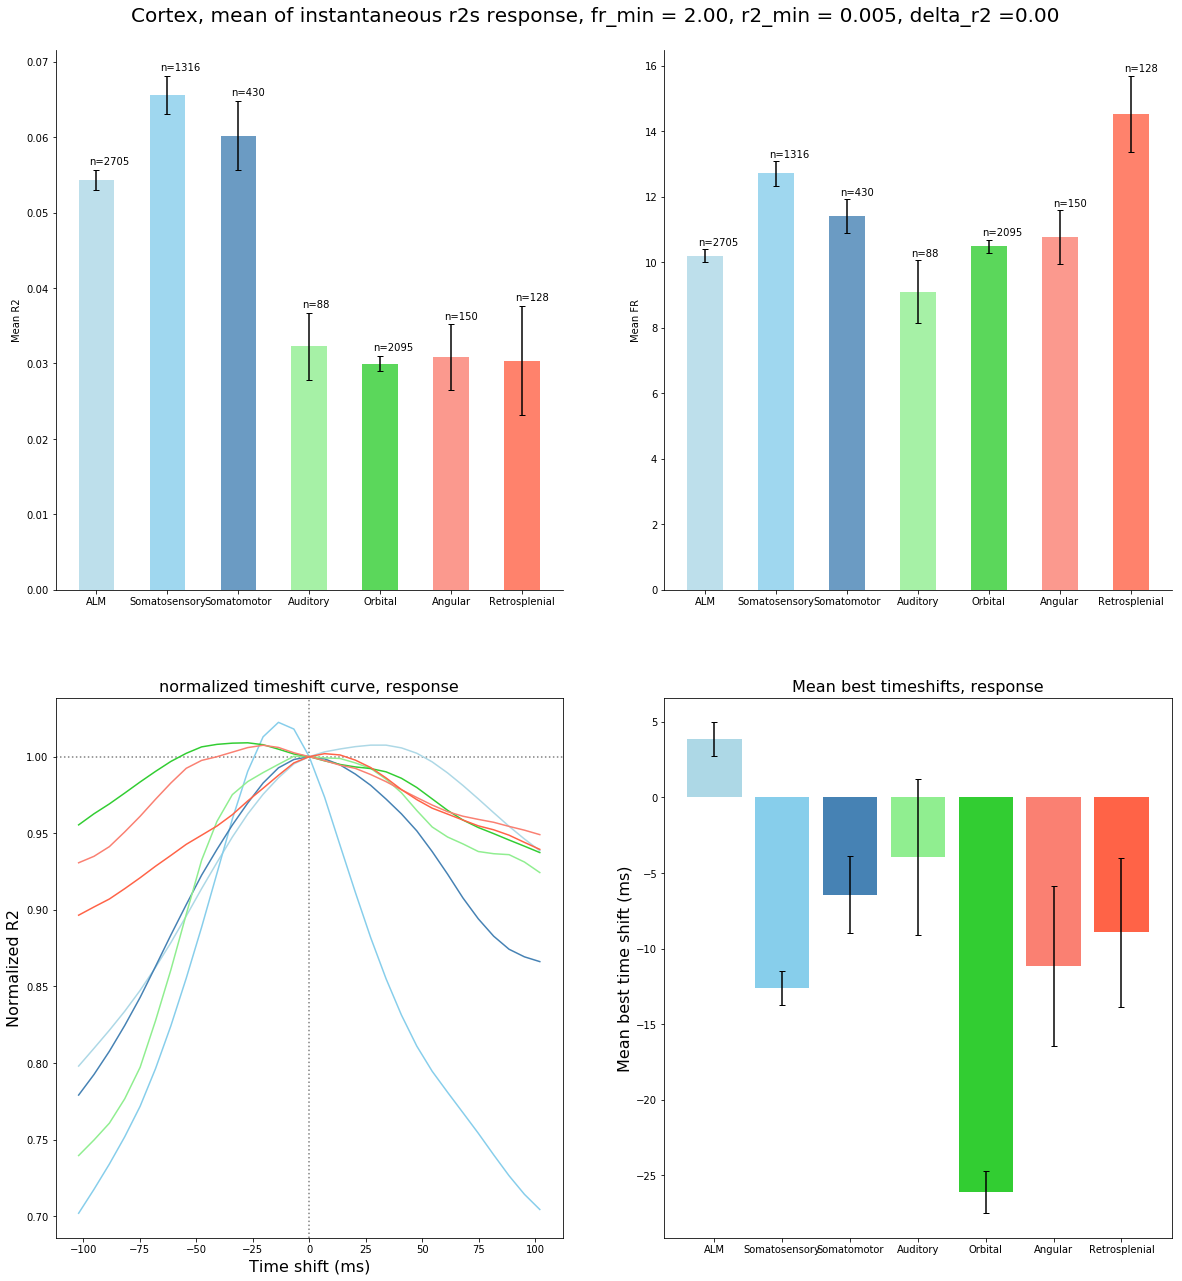

In [22]:
create_summary_plot(use_cortex_list, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_cortex_names, titlestr = 'Cortex, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=2.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'cortex_r2_response.png', bbox_inches = 'tight')

In [23]:
medulla_use_nuclei = [
    'Medulla, sensory related',
    'Gigantocellular reticular nucleus',
    'Intermediate reticular nucleus',
    'Magnocellular reticular nucleus',
    'Parvicellular reticular nucleus',
    'Vestibular nuclei',
]

medulla_short_names = [
    'Sensory medulla',
    'Gigantocellular',
    'Intermediate',
    'Magnocellular',
    'Parvicellular',
    'Vestibular'
]

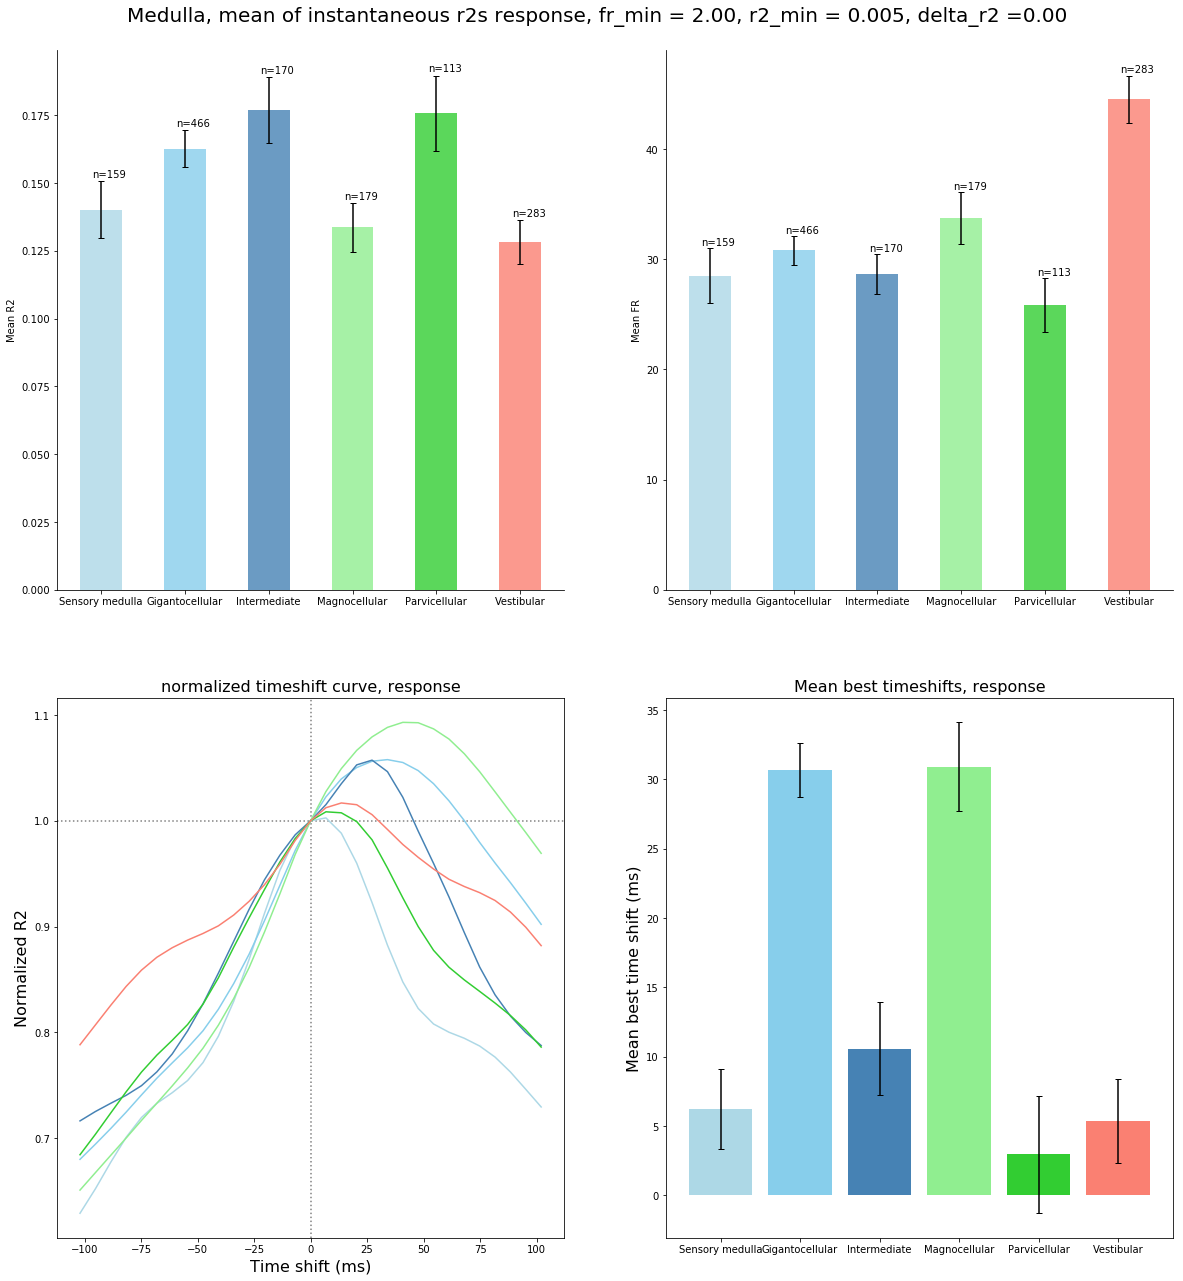

In [24]:
create_summary_plot(medulla_use_nuclei, cc, r2_new, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = medulla_short_names, titlestr = 'Medulla, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=2.0, delta_r2=0.,n_min= 80)
plt.savefig(figfolder + 'medulla_r2_response.png', bbox_inches = 'tight')

In [25]:
# Striatum

Striatum_subregions = func.get_n_layer_down_subregions_from_name(df, 'Striatum', 1)['region'].values
Striatum_subregions_annotations = {}
for subregion in Striatum_subregions:
    Striatum_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, Striatum_subregions_annotations)
medial_lateral_cutoff = 2500

dorsal_inds = {'Striatum dorsal region, medial': [], 'Striatum dorsal region, lateral': []}
for ii in inds['Striatum dorsal region']:
    ccf_x = ccf_coords[ii][0]
    if np.abs(ccf_x ) < medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, medial'].append(ii)
    elif np.abs(ccf_x ) > medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, lateral'].append(ii)

joint_inds = {}
for k in dorsal_inds.keys():
    joint_inds[k] = np.array(dorsal_inds[k])

for k in inds.keys():
    if k != 'Striatum dorsal region':
        joint_inds[k] = inds[k]

use_Striatum_nuclei = list(joint_inds.keys())

joint_color_list = ['grey', 'black', 'blue', 'green']

striatum_short_names = [
    'Dorsal medial',
    'Dorsal lateral',
    'Ventral',
    'Lateral septal',
    'Str-like amyg'
]

fr_threshold = 2
r2_threshold = 0.005
delta_r2 = 0.
n_min = 80

axis_names = striatum_short_names
titlestr = 'Striatum mean of instantaenous r2, '
inds = joint_inds
region_list = use_Striatum_nuclei


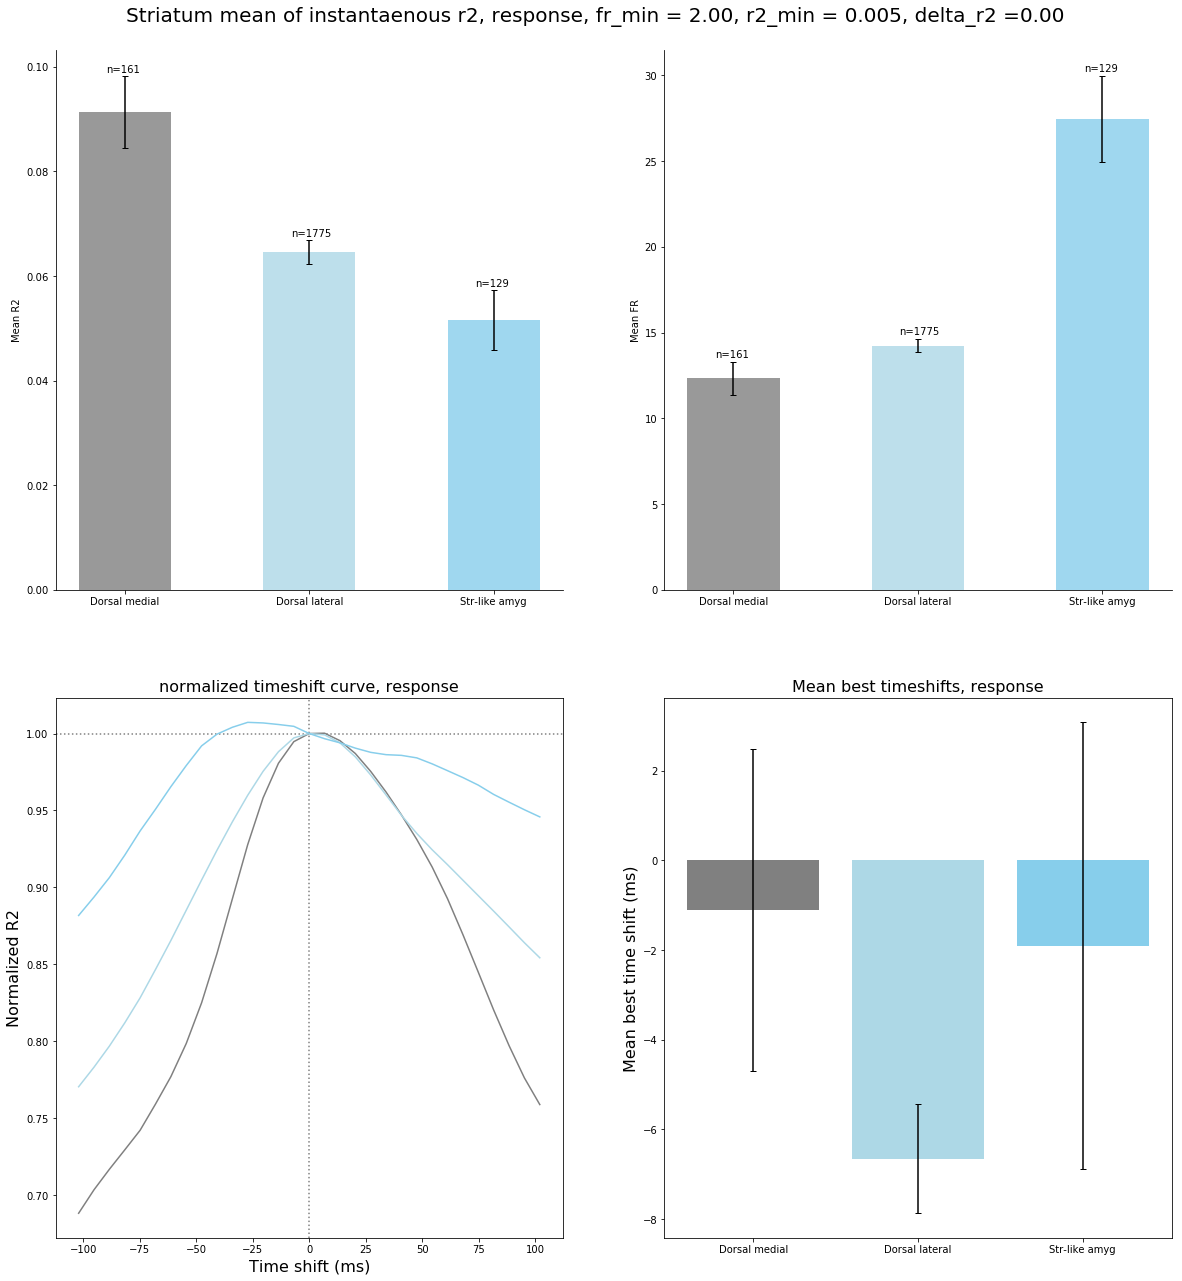

In [23]:
r2 = []
fr = r2_new['5_0']['avg_fr'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

r2 = np.array(r2)
if r2_method == 'old_clipped':
    r2[r2 < 0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
#delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
#threshold_inds = np.intersect1d(threshold_inds, delta_inds)

_inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

use_regions = list(use_inds.keys())

use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]
f = plt.figure(figsize=(20,20))
f.suptitle(titlestr + '%s, fr_min = %.2f, r2_min = %.3f, delta_r2 =%.2f'%(epoch,fr_threshold,r2_threshold,delta_r2), fontsize=20)

ax_bar = f.add_subplot(2,2,1)
create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean R2', 'r2', r2_method, epoch,)

ax_bar = f.add_subplot(2,2,2)
create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean FR', 'fr', r2_method, epoch,)

ax_bar = f.add_subplot(2,2,3)
create_timeshift_curves_plot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch)

ax_bar = f.add_subplot(2,2,4)
create_timeshift_barplot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch,)
plt.subplots_adjust(top=0.95)


plt.savefig(figfolder + 'striatum_r2_response.png', bbox_inches = 'tight')

## Marker based prediction

In [6]:
r2_marker = pickle.load(open(datafolder + 'r2_data_dict_marker_smallwindow_subtract_pertimeavg.pkl', 'rb'))


ccf_labels_marker = r2_marker['5_0']['ccf_labels'].copy()
ccf_coords_marker = r2_marker['5_0']['ccf_coords'].copy()
is_alm_marker = r2_marker['5_0']['is_alm'].copy()

alm_inds_marker = np.where(is_alm_marker)[0]

Sessions are misaligned in the two dataset, so we first have to take care of that.

In [7]:
sessions = r2_new['5_0']['session_name'].copy()
marker_sessions = r2_marker['5_0']['session_name'].copy()

In [8]:
session_align_inds = []

current_session = ''
for session in marker_sessions:
    if session != current_session:
        current_session = session
        session_align_inds.append(np.where(sessions == session)[0])

session_align_inds = np.concatenate(session_align_inds)

In [9]:
np.sum(sessions[session_align_inds] == marker_sessions)

41284

In [10]:
np.sum(ccf_coords[session_align_inds] == ccf_coords_marker)/3

41284.0

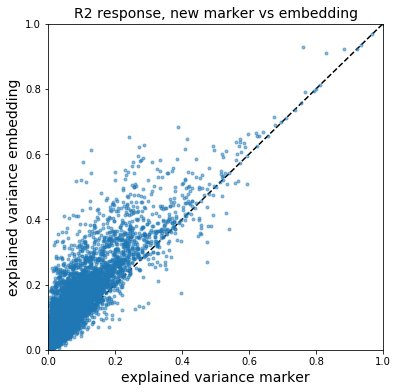

In [11]:
fr = r2_marker['5_0']['avg_fr'].copy()

fr_mask = fr > 2

epoch = 'response'
r2method = 'new'

r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()
r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()

if r2method == 'old_clipped':
    r2_mar[r2_mar<0] = 0
    r2_emb[r2_emb<0] = 0

plt.figure(figsize = (6,6))
plt.title('R2 %s, %s marker vs embedding'%(epoch,r2method), fontsize = 14)
plt.xlabel('explained variance marker', fontsize = 14)
plt.ylabel('explained variance embedding', fontsize = 14)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.plot(r2_mar[fr_mask], r2_emb[session_align_inds][fr_mask], '.', alpha = 0.5)

plt.savefig(figfolder + 'r2_marker_vs_embedding_%s_%s.png'%(epoch,r2method), bbox_inches = 'tight')

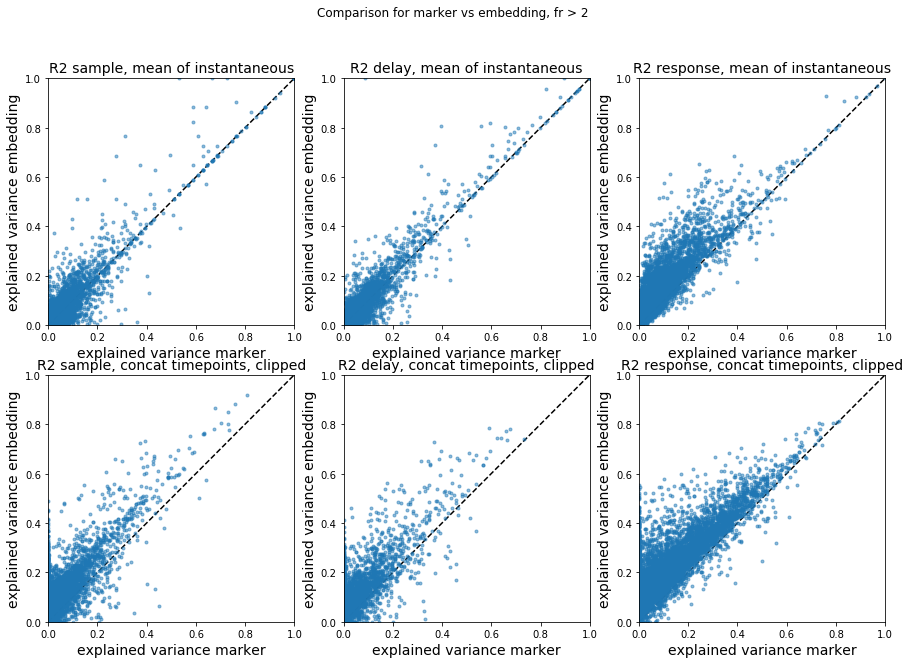

In [22]:
plt.subplots(2,3, figsize = (15,10))
plt.suptitle('Comparison for marker vs embedding, fr > 2')

fr = r2_marker['5_0']['avg_fr'].copy()
fr_mask = fr > 2

titlestr_dict = {'new': 'mean of instantaneous', 'old_clipped': 'concat timepoints, clipped'}

for epoch in ['sample','delay','response']:
    for r2method in ['new','old_clipped']:
        r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()
        r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()

        if r2method == 'old_clipped':
            r2_mar[r2_mar<0] = 0
            r2_emb[r2_emb<0] = 0

        plt.subplot(2,3, 1 + ['sample','delay','response'].index(epoch) + 3* ['new','old_clipped'].index(r2method))
        plt.title('R2 %s, %s'%(epoch,titlestr_dict[r2method]), fontsize = 14)
        plt.xlabel('explained variance marker', fontsize = 14)
        plt.ylabel('explained variance embedding', fontsize = 14)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.plot([0,1],[0,1],'k--')
        plt.plot(r2_mar[fr_mask], r2_emb[session_align_inds][fr_mask], '.', alpha = 0.5)

plt.savefig(figfolder + 'r2_marker_vs_embedding_all_singleneuron.png', bbox_inches = 'tight')
        #plt.savefig(figfolder + 'r2_marker_vs_embedding_%s_%s.png'%(epoch,r2method), bbox_inches = 'tight')

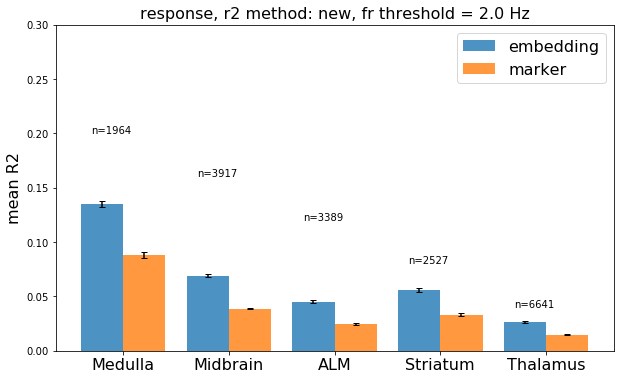

In [12]:
epoch = 'response'
r2method = 'new'
fr_cutoff = 2
r2method_string = method_to_string[r2method]

r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()[session_align_inds]
r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
if r2method == 'old_clipped':
    r2_emb[r2_emb<0] = 0
    r2_mar[r2_mar<0] = 0

fr = r2_marker['5_0']['avg_fr'].copy()

fr_inds = np.where(fr>fr_cutoff)[0]

ccf_labels_marker = r2_marker['5_0']['ccf_labels'].copy()

area_values_emb = []
area_sems_emb = []
area_values_mar = []
area_sems_mar = []
n_neurons = []
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds.copy()
    else:
        inds = get_single_area_inds(area, df, ccf_labels_marker)
    inds = np.intersect1d(inds, fr_inds)
    n_neurons.append(len(inds))
    mean_emb = r2_emb[inds].mean()
    std_emb = r2_emb[inds].std()
    sem_emb = std_emb/np.sqrt(inds.shape[0])
    area_values_emb.append(mean_emb)
    area_sems_emb.append(sem_emb)

    mean_mar = r2_mar[inds].mean()
    std_mar = r2_mar[inds].std()
    sem_mar = std_mar/np.sqrt(inds.shape[0])
    area_values_mar.append(mean_mar)
    area_sems_mar.append(sem_mar)


plt.figure(figsize = (10,6))

plt.bar(np.arange(0,len(areas)) - 0.2, 
    area_values_emb, yerr = area_sems_emb, alpha = 0.8, 
    capsize = 3, width=0.4, label = 'embedding')

plt.bar(np.arange(0,len(areas)) + 0.2,
    area_values_mar, yerr = area_sems_mar, alpha = 0.8, 
    capsize = 3, width=0.4, label = 'marker')



plt.xticks(np.arange(0,len(areas)), areas, rotation = 0, fontsize = 16);
plt.ylabel('mean R2',fontsize = 16)
plt.title('%s, r2 method: %s, fr threshold = %.1f Hz'%(epoch, r2method,fr_cutoff), fontsize = 16)
for j in range(len(areas)):
    plt.text(j-0.3,0.2-0.04*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')

plt.ylim(0,0.30)
plt.legend(fontsize = 16)
plt.savefig(figfolder + 'r2_marker_vs_embedding_%s_%s_barplot.png'%(epoch,r2method), bbox_inches = 'tight')

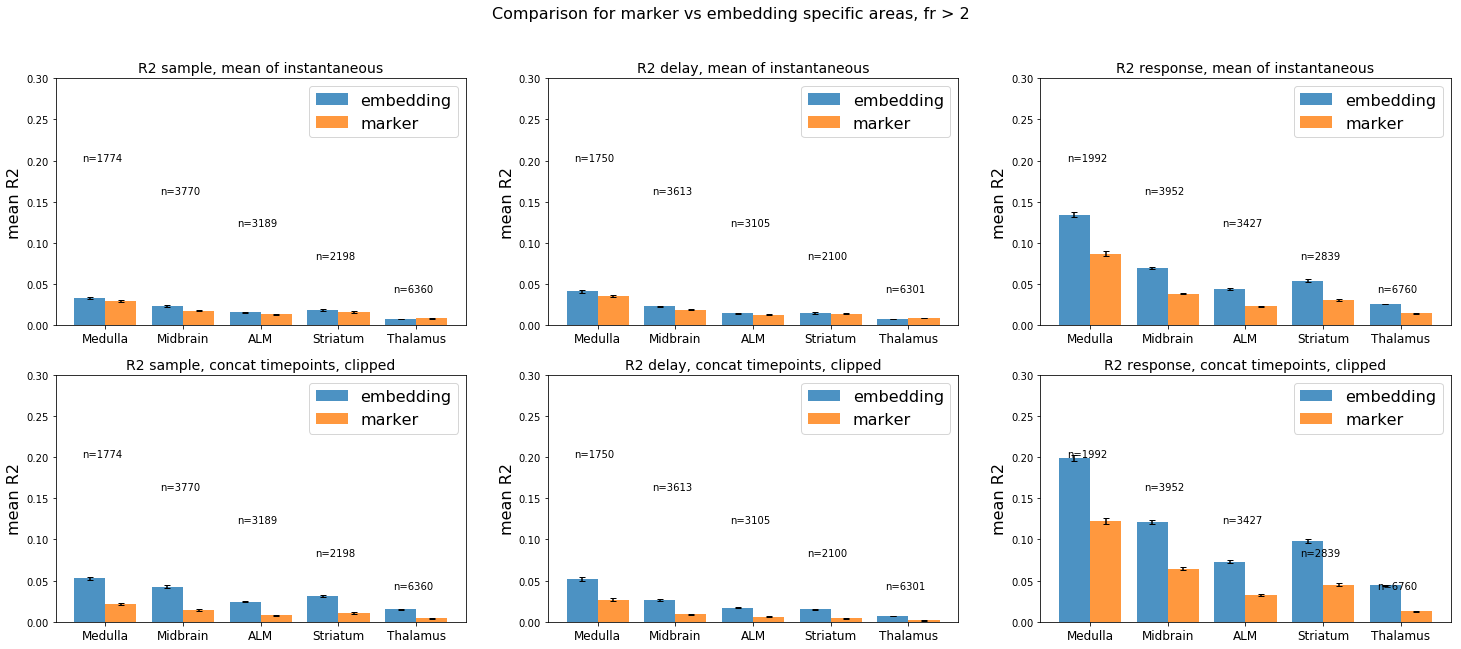

In [28]:
plt.subplots(2,3, figsize = (25,10))
plt.suptitle('Comparison for marker vs embedding specific areas, fr > 2', fontsize = 16)

fr = r2_marker['5_0']['avg_fr'].copy()
fr_mask = fr > 2

titlestr_dict = {'new': 'mean of instantaneous', 'old_clipped': 'concat timepoints, clipped'}

for epoch in ['sample','delay','response']:
    for r2method in ['new','old_clipped']:
        r2method_string = method_to_string[r2method]

        r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()[session_align_inds]
        r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        if r2method == 'old_clipped':
            r2_emb[r2_emb<0] = 0
            r2_mar[r2_mar<0] = 0

        fr = r2_marker['5_0']['%s_fr'%epoch].copy()

        fr_inds = np.where(fr>fr_cutoff)[0]

        ccf_labels_marker = r2_marker['5_0']['ccf_labels'].copy()

        area_values_emb = []
        area_sems_emb = []
        area_values_mar = []
        area_sems_mar = []
        n_neurons = []
        for j, area in enumerate(areas):
            if area == 'ALM':
                inds = alm_inds.copy()
            else:
                inds = get_single_area_inds(area, df, ccf_labels_marker)
            inds = np.intersect1d(inds, fr_inds)
            n_neurons.append(len(inds))
            mean_emb = r2_emb[inds].mean()
            std_emb = r2_emb[inds].std()
            sem_emb = std_emb/np.sqrt(inds.shape[0])
            area_values_emb.append(mean_emb)
            area_sems_emb.append(sem_emb)

            mean_mar = r2_mar[inds].mean()
            std_mar = r2_mar[inds].std()
            sem_mar = std_mar/np.sqrt(inds.shape[0])
            area_values_mar.append(mean_mar)
            area_sems_mar.append(sem_mar)


        plt.subplot(2,3, 1 + ['sample','delay','response'].index(epoch) + 3* ['new','old_clipped'].index(r2method))

        plt.bar(np.arange(0,len(areas)) - 0.2, 
            area_values_emb, yerr = area_sems_emb, alpha = 0.8, 
            capsize = 3, width=0.4, label = 'embedding')

        plt.bar(np.arange(0,len(areas)) + 0.2,
            area_values_mar, yerr = area_sems_mar, alpha = 0.8, 
            capsize = 3, width=0.4, label = 'marker')



        plt.xticks(np.arange(0,len(areas)), areas, rotation = 0, fontsize = 12);
        plt.ylabel('mean R2',fontsize = 16)
        plt.title('R2 %s, %s'%(epoch,titlestr_dict[r2method]), fontsize = 14)
        for j in range(len(areas)):
            plt.text(j-0.3,0.2-0.04*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.30)
        plt.legend(fontsize = 16)

plt.savefig(figfolder + 'r2_marker_vs_embedding_all_areas_barplot.png', bbox_inches = 'tight')

In [16]:
for _epoch in ['sample', 'delay','response']:
    print('%s epoch'%_epoch)
    print('marker: %.3f, embedding: %.3f'%(
        np.sum(r2_marker['5_0']['%s_r2_old'%_epoch] < 0) / r2_marker['5_0']['%s_r2_old'%_epoch].shape[0], 
        np.sum(r2_new['5_0']['%s_r2_old'%_epoch] < 0) / r2_new['5_0']['%s_r2_old'%_epoch].shape[0]))

sample epoch
marker: 0.925, embedding: 0.601
delay epoch
marker: 0.939, embedding: 0.673
response epoch
marker: 0.786, embedding: 0.428


#### Some nicer plots

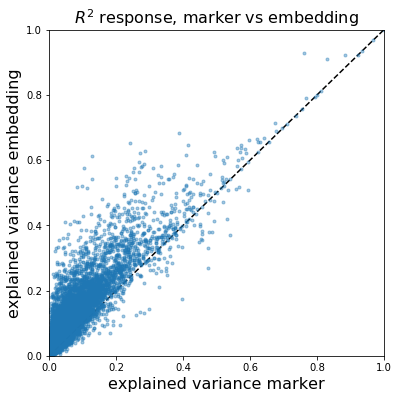

In [11]:
fr = r2_marker['5_0']['avg_fr'].copy()

fr_mask = fr > 2

epoch = 'response'
r2method = 'new'

r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()
r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2method])].copy()

if r2method == 'old_clipped':
    r2_mar[r2_mar<0] = 0
    r2_emb[r2_emb<0] = 0

plt.figure(figsize = (6,6))
plt.title(r'$R^2$ %s, marker vs embedding'%(epoch), fontsize = 16)
plt.xlabel('explained variance marker', fontsize = 16)
plt.ylabel('explained variance embedding', fontsize = 16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.plot(r2_mar[fr_mask], r2_emb[session_align_inds][fr_mask], '.', alpha = 0.4)

plt.savefig(figfolder + 'r2_marker_vs_embedding_%s_%s_nice.png'%(epoch,r2method), bbox_inches = 'tight', dpi = 300)

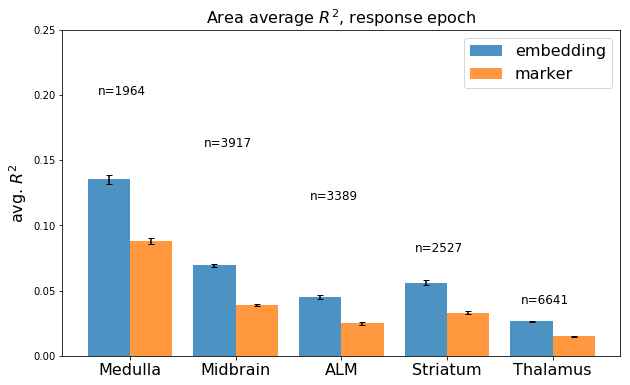

In [12]:
epoch = 'response'
r2method = 'new'
fr_cutoff = 2
r2method_string = method_to_string[r2method]

r2_emb = r2_new['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()[session_align_inds]
r2_mar = r2_marker['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
if r2method == 'old_clipped':
    r2_emb[r2_emb<0] = 0
    r2_mar[r2_mar<0] = 0

fr = r2_marker['5_0']['avg_fr'].copy()

fr_inds = np.where(fr>fr_cutoff)[0]

ccf_labels_marker = r2_marker['5_0']['ccf_labels'].copy()

area_values_emb = []
area_sems_emb = []
area_values_mar = []
area_sems_mar = []
n_neurons = []
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds.copy()
    else:
        inds = get_single_area_inds(area, df, ccf_labels_marker)
    inds = np.intersect1d(inds, fr_inds)
    n_neurons.append(len(inds))
    mean_emb = r2_emb[inds].mean()
    std_emb = r2_emb[inds].std()
    sem_emb = std_emb/np.sqrt(inds.shape[0])
    area_values_emb.append(mean_emb)
    area_sems_emb.append(sem_emb)

    mean_mar = r2_mar[inds].mean()
    std_mar = r2_mar[inds].std()
    sem_mar = std_mar/np.sqrt(inds.shape[0])
    area_values_mar.append(mean_mar)
    area_sems_mar.append(sem_mar)


plt.figure(figsize = (10,6))

plt.bar(np.arange(0,len(areas)) - 0.2, 
    area_values_emb, yerr = area_sems_emb, alpha = 0.8, 
    capsize = 3, width=0.4, label = 'embedding')

plt.bar(np.arange(0,len(areas)) + 0.2,
    area_values_mar, yerr = area_sems_mar, alpha = 0.8, 
    capsize = 3, width=0.4, label = 'marker')



plt.xticks(np.arange(0,len(areas)), areas, rotation = 0, fontsize = 16);
plt.ylabel(r'avg. $R^2$',fontsize = 16)
plt.title(r'Area average $R^2$, %s epoch'%(epoch), fontsize = 16)
for j in range(len(areas)):
    plt.text(j-0.3,0.2-0.04*j, 'n=%d'%n_neurons[j], fontsize=12, color='black')

plt.ylim(0,0.25)
plt.legend(fontsize = 16)
plt.savefig(figfolder + 'r2_marker_vs_embedding_%s_%s_barplot_nice.png'%(epoch,r2method), bbox_inches = 'tight', dpi = 300)